In [1]:
import pickle
import torch
import os
import numpy as np
import torch.nn as nn
from train import ResNet18, ResNet50,RetinopathyDataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision.models as models
import matplotlib.pyplot as plt

In [2]:
def evaluate(model, loader):
    model.eval()
    ans, pred = [], []
    with torch.no_grad():
        for data,label in loader:
            data, label = data.to(device), label.to(device)
            out = model.forward(data)
            out = torch.argmax(out, dim=1)
            ans  += label.detach().cpu().numpy().tolist()
            pred += out.detach().cpu().numpy().tolist()
    return ans,pred

def plot(train_acc,pre_train_acc,test_acc, pre_test_acc,title='ResNet18'):
    plt.title(title)
    episodes = list(range(1,len(train_acc)+1))
    plt.plot(episodes,train_acc,label="train")
    plt.plot(episodes,test_acc,label="test")
    plt.plot(episodes,pre_train_acc,label="train (pretrained)")
    plt.plot(episodes,pre_test_acc,label="test (pretrained)")    
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    plt.legend()
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred,title, labels=[0, 1, 2, 3, 4]):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)), normalize='true')
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='.1f')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground truth')
    ax.xaxis.set_ticklabels(labels, rotation=45)
    ax.yaxis.set_ticklabels(labels, rotation=0)
    plt.title(title)
    plt.show()
    #plt.savefig(fn, dpi=300)

In [3]:
def show_pred_result(model, device, weight_path, title):
    
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features,5)
    model.load_state_dict(torch.load(weight_path))
    model.to(device)
    test_dataset = RetinopathyDataset('data/', 'test')
    test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)
    ans,pred = evaluate(model,test_loader)
    plot_confusion_matrix(ans,pred,title)


def show_acc_result(res,pre_res,title):
    with open(res, 'rb') as f:
        res_dict = pickle.load(f)
    train_acc = res_dict['train_acc']
    test_acc = res_dict['test_acc']
    with open(pre_res, 'rb') as f:
        pre_res_dict = pickle.load(f)
    pre_train_acc = pre_res_dict['train_acc']
    pre_test_acc = pre_res_dict['test_acc']
    plot(train_acc,pre_train_acc,test_acc, pre_test_acc,title=title)

Use GPU for training...
> Found 7025 images...


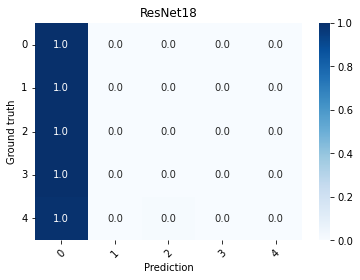

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 16
test_kwargs = {'batch_size': 1}

if use_cuda:
    print("Use GPU for training...")
    cuda_kwargs = {'num_workers': 32,
                   'pin_memory': True,
                   'shuffle': False}
    test_kwargs.update(cuda_kwargs)
else:
    print("Use CPU to training...")

show_pred_result(ResNet18(), device, os.path.join("models","resnet18","epoch10.cpt"), "ResNet18")

> Found 7025 images...


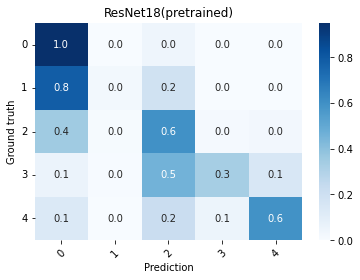

In [5]:
show_pred_result(models.resnet18(), device, os.path.join("models","resnet18_pre","epoch10.cpt"), "ResNet18(pretrained)")

> Found 7025 images...


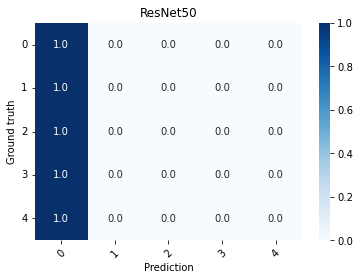

In [6]:
show_pred_result(ResNet50(), device, os.path.join("models","resnet50","epoch4.cpt"), "ResNet50")

> Found 7025 images...


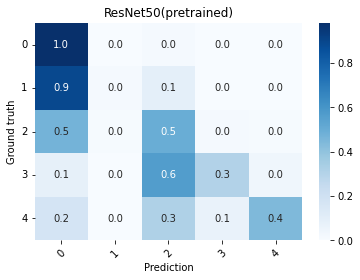

In [7]:
show_pred_result(models.resnet50(), device, os.path.join("models","resnet50_pre","epoch4.cpt"), "ResNet50(pretrained)")

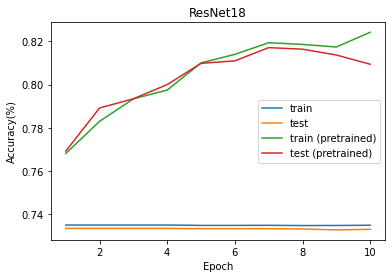

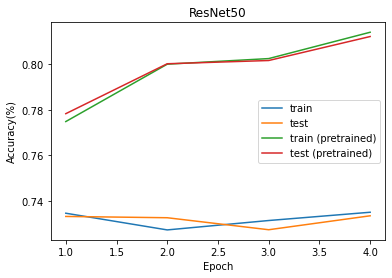

In [8]:
show_acc_result(
    os.path.join("logs","resnet18","2022_04_20_10:58:28_pm.pickle"),
    os.path.join("logs","resnet18_pre","2022_04_20_10:59:21_pm.pickle"),
    "ResNet18"
)
show_acc_result(
    os.path.join("logs","resnet50","2022_04_20_11:54:06_pm.pickle"),
    os.path.join("logs","resnet50_pre","2022_04_20_11:54:13_pm.pickle"),
    "ResNet50"
)